# Temporal Distribution Summary

**Single comprehensive figure showing dataset temporal concentration.**

---

## 1. Setup & Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.append('../../dsa4263_group_project')
from data_cleaning_finalized import DataCleaner
from temporal_feature_engineering import TemporalFeatureEngineer

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ Setup complete")

✅ Setup complete


## 2. Load and Clean Data

In [25]:
DATA_PATH = Path('../../data/processed/date_merge.csv')
df = pd.read_csv(DATA_PATH)
print(f"✅ Loaded: {df.shape}")

original_count = len(df)
cleaner = DataCleaner()
df_cleaned = cleaner.clean_dates(df, date_col='date')
retention_rate = (len(df_cleaned) / original_count) * 100
print(f"✅ Cleaned: {len(df_cleaned):,} rows ({retention_rate:.1f}% retention)")

✅ Loaded: (49301, 7)
Timezone: 48,213 present, 1,088 missing (2.2%)
Dropped: 77 unparseable dates (0.2%)
Date cleaning: 49,224/49,301 retained (99.8%)
✅ Cleaned: 49,224 rows (99.8% retention)


## 3. Extract Temporal Features

In [18]:
# Add all temporal features using TemporalFeatureEngineer
engineer = TemporalFeatureEngineer()

# Process all: adds timezone_region, utc_date, and basic temporal features
df_cleaned = engineer.process_all(df_cleaned, local_date_col='date', 
                                   tz_offset_col='timezone_offset',
                                   extract_features=True, drop_offset=False)

# Add all advanced features (is_night, sender history, time gaps)
df_cleaned = engineer.add_all_advanced_features(df_cleaned, sender_col='sender',
                                                 utc_date_col='utc_date', 
                                                 label_col='label', hour_col='hour')

print(f"✅ All temporal features added")
print(f"\nNew columns added: {[c for c in df_cleaned.columns if c in ['timezone_region', 'utc_date', 'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'month_name', 'day_name', 'is_night', 'sender_historical_phishing_rate', 'sender_historical_count', 'current_time_gap', 'sender_time_gap_std']]}")
print(f"\nFinal shape: {df_cleaned.shape}")

UTC date: 1,070 missing timezones assumed UTC (2.2%)
⚠ Sorting by 'utc_date' for temporal consistency...
✓ Sorted 49,224 rows
Adding advanced temporal features...
⚠ Using baseline from current data: 0.5652
✓ Advanced features added: 49,224 rows
✅ All temporal features added

New columns added: ['timezone_region', 'utc_date', 'year', 'month', 'month_name', 'day', 'day_of_week', 'day_name', 'hour', 'minute', 'is_night', 'sender_historical_count', 'sender_historical_phishing_rate', 'current_time_gap', 'sender_time_gap_std']

Final shape: (49224, 24)


/Users/cindy/Downloads/DSA4263_Group_Project/notebooks/yongrui/../../dsa4263_group_project/temporal_feature_engineering.py:362: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sender_historical_phishing_rate'].fillna(global_baseline, inplace=True)


## 4. Distribution Summary

✅ Saved: ../../figures/4.2.3_temporal_distribution.png
   Resolution: 300 DPI
   Size: 0.51 MB


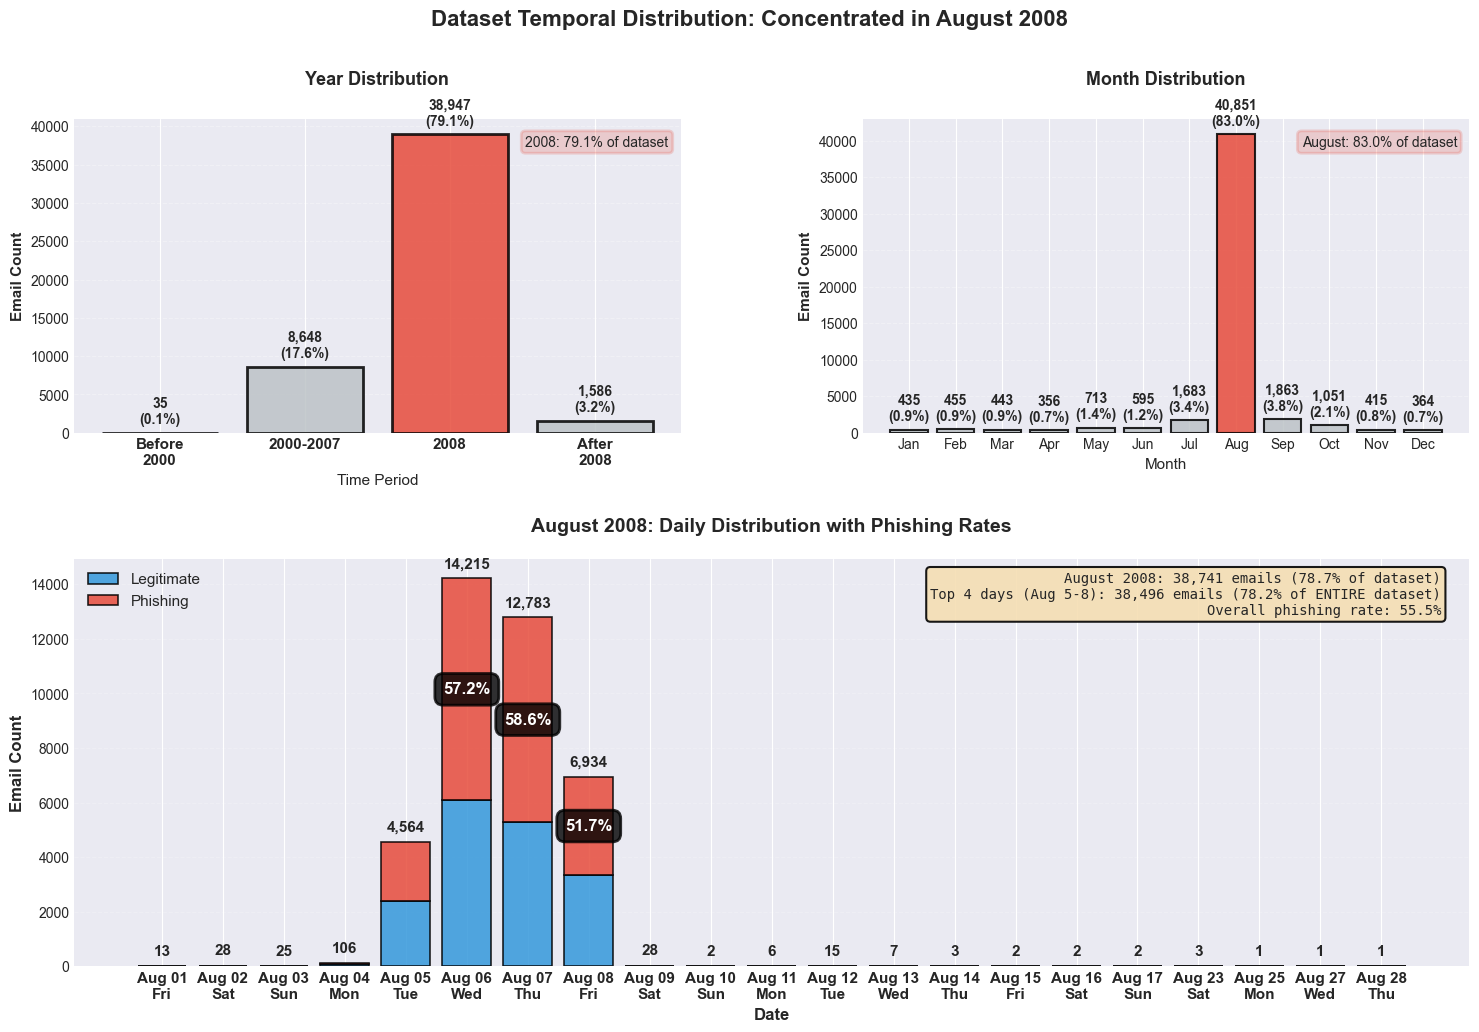

In [19]:
OUTPUT_DIR = Path('../../figures')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Create figure
fig = plt.figure(figsize=(18, 11))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.3, height_ratios=[1, 1.3])

# Year - Aggregated
ax1 = fig.add_subplot(gs[0, 0])
year_counts = df_cleaned['year'].value_counts()
before_2000 = sum([year_counts.get(y, 0) for y in range(1900, 2000)])
y2000_2007 = sum([year_counts.get(y, 0) for y in range(2000, 2008)])
y2008 = year_counts.get(2008, 0)
after_2008 = sum([year_counts.get(y, 0) for y in range(2009, 2030)])
year_periods = ['Before\n2000', '2000-2007', '2008', 'After\n2008']
year_values = [before_2000, y2000_2007, y2008, after_2008]
year_colors_agg = ['#BDC3C7', '#BDC3C7', '#E74C3C', '#BDC3C7']
bars1 = ax1.bar(range(len(year_periods)), year_values, color=year_colors_agg, 
                alpha=0.85, edgecolor='black', linewidth=2)
ax1.set_xticks(range(len(year_periods)))
ax1.set_xticklabels(year_periods, fontsize=11, fontweight='bold')
ax1.set_title('Year Distribution', fontsize=13, fontweight='bold', pad=25)
ax1.set_ylabel('Email Count', fontsize=11, fontweight='bold')
ax1.set_xlabel('Time Period', fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(year_values):
    if v > 0:
        pct = (v / len(df_cleaned)) * 100
        ax1.text(i, v + max(year_values)*0.02, f'{v:,}\n({pct:.1f}%)', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
pct_2008 = (y2008 / len(df_cleaned)) * 100
ax1.text(0.98, 0.95, f'2008: {pct_2008:.1f}% of dataset', 
         transform=ax1.transAxes, fontsize=10, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='#E74C3C', alpha=0.2, edgecolor='#E74C3C', linewidth=2))

# Month
ax2 = fig.add_subplot(gs[0, 1])
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_full = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']
month_data = df_cleaned['month_name'].value_counts()
month_data_ordered = pd.Series([month_data.get(m, 0) for m in month_full], index=month_order)
month_colors = ['#E74C3C' if m == 'Aug' else '#BDC3C7' for m in month_order]
bars2 = ax2.bar(range(12), month_data_ordered.values, color=month_colors, 
                alpha=0.85, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(12))
ax2.set_xticklabels(month_order, fontsize=10)
ax2.set_title('Month Distribution', fontsize=13, fontweight='bold', pad=25)
ax2.set_ylabel('Email Count', fontsize=11, fontweight='bold')
ax2.set_xlabel('Month', fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(month_data_ordered.values):
    if v > 0:
        pct = (v / len(df_cleaned)) * 100
        ax2.text(i, v + max(month_data_ordered.values)*0.02, f'{v:,}\n({pct:.1f}%)', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
aug_count = month_data.get('August', 0)
pct_aug = (aug_count / len(df_cleaned)) * 100
ax2.text(0.98, 0.95, f'August: {pct_aug:.1f}% of dataset', 
         transform=ax2.transAxes, fontsize=10, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='#E74C3C', alpha=0.2, edgecolor='#E74C3C', linewidth=2))

# August 2008
ax3 = fig.add_subplot(gs[1, :])
august_2008 = df_cleaned[(df_cleaned['year'] == 2008) & (df_cleaned['month'] == 8)].copy()

if len(august_2008) > 0:
    date_counts = august_2008['date_only'].value_counts().sort_index()
    date_label_counts = august_2008.groupby(['date_only', 'label']).size().unstack(fill_value=0)
    date_label_counts = date_label_counts.reindex(date_counts.index)
    
    phishing_rates = {}
    for date in date_counts.index:
        date_data = august_2008[august_2008['date_only'] == date]
        phishing_count = (date_data['label'] == 1).sum()
        total_count = len(date_data)
        phishing_rates[date] = (phishing_count / total_count * 100) if total_count > 0 else 0
    
    top_4_dates = date_counts.nlargest(4).index
    # Exclude Aug 05 from showing phishing rate label
    import datetime
    aug_05 = datetime.date(2008, 8, 5)
    dates_to_label = [d for d in top_4_dates if d != aug_05]
    
    x_pos = range(len(date_counts))
    
    if 0 in date_label_counts.columns:
        bars_legit = ax3.bar(x_pos, date_label_counts[0], label='Legitimate', 
                             color='#3498DB', alpha=0.85, edgecolor='black', linewidth=1.2)
    if 1 in date_label_counts.columns:
        bottom_vals = date_label_counts[0] if 0 in date_label_counts.columns else 0
        bars_phish = ax3.bar(x_pos, date_label_counts[1], bottom=bottom_vals, 
                            label='Phishing', color='#E74C3C', alpha=0.85, edgecolor='black', linewidth=1.2)
    
    ax3.set_xticks(x_pos)
    date_labels = [d.strftime('%b %d\n%a') for d in date_counts.index]
    ax3.set_xticklabels(date_labels, fontsize=11, fontweight='bold')
    ax3.set_title('August 2008: Daily Distribution with Phishing Rates', 
                  fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Email Count', fontsize=12, fontweight='bold')
    ax3.legend(loc='upper left', fontsize=11, framealpha=0.95, edgecolor='black')
    ax3.grid(axis='y', alpha=0.2, linestyle='--')
    
    for i, (date, total) in enumerate(zip(date_counts.index, date_counts.values)):
        ax3.text(i, total + max(date_counts.values)*0.02, f'{total:,}', 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Only show phishing rate labels for dates_to_label (excludes Aug 05)
    for i, date in enumerate(date_counts.index):
        if date in dates_to_label:
            rate = phishing_rates[date]
            phish_count = date_label_counts.loc[date, 1] if 1 in date_label_counts.columns else 0
            legit_count = date_label_counts.loc[date, 0] if 0 in date_label_counts.columns else 0
            y_pos = legit_count + (phish_count / 2)
            ax3.text(i, y_pos, f'{rate:.1f}%', 
                     ha='center', va='center', fontsize=12, fontweight='bold',
                     color='white', 
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='black', alpha=0.8, linewidth=2))
    
    top_4_count = date_counts[top_4_dates].sum()
    pct_main_4 = (top_4_count / len(df_cleaned)) * 100
    overall_phishing_rate = (august_2008['label']==1).sum()/len(august_2008)*100
    
    info_text = (
        f"August 2008: {len(august_2008):,} emails ({len(august_2008)/len(df_cleaned)*100:.1f}% of dataset)\n"
        f"Top 4 days (Aug 5-8): {top_4_count:,} emails ({pct_main_4:.1f}% of ENTIRE dataset)\n"
        f"Overall phishing rate: {overall_phishing_rate:.1f}%"
    )
    ax3.text(0.98, 0.97, info_text, transform=ax3.transAxes, 
             fontsize=10, verticalalignment='top', horizontalalignment='right', family='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=1.5))

fig.suptitle('Dataset Temporal Distribution: Concentrated in August 2008', 
             fontsize=16, fontweight='bold', y=0.98)

output_file = OUTPUT_DIR / '4.2.3_temporal_distribution.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')

print(f"✅ Saved: {output_file}")
print(f"   Resolution: 300 DPI")
print(f"   Size: {output_file.stat().st_size / (1024*1024):.2f} MB")

plt.show()
plt.close()

✅ Saved: ../../figures/4.2.3_geographic_distribution.png


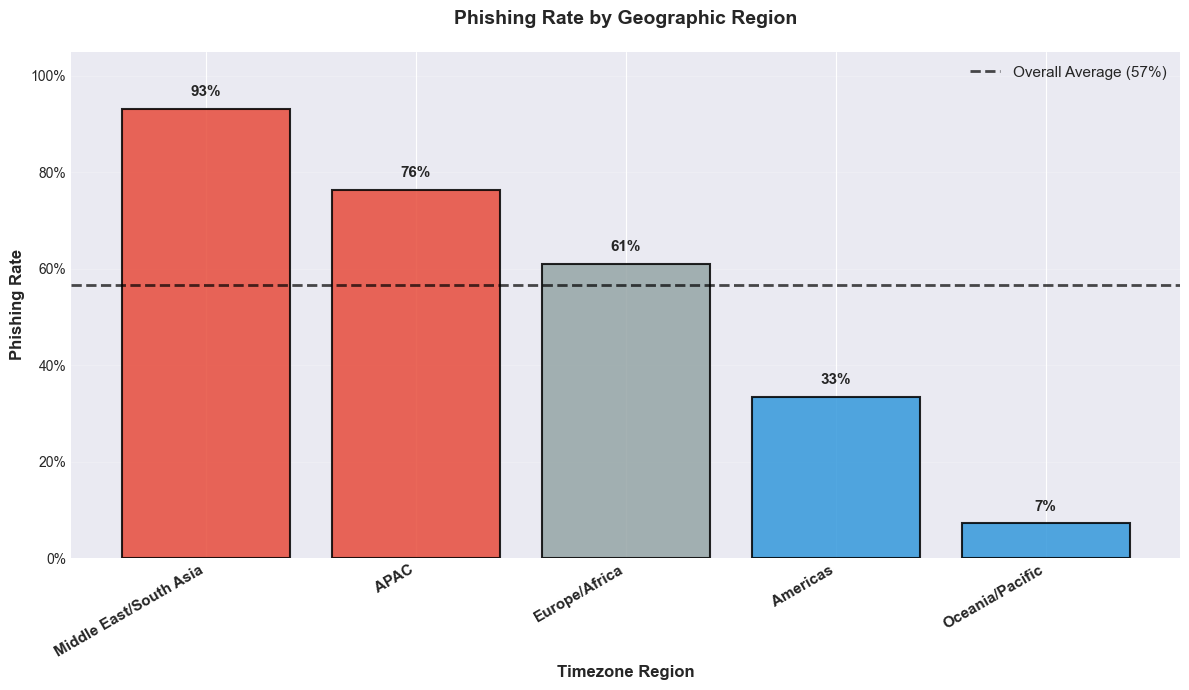

In [20]:
# --- Geographic Distribution Summary ---

# Filter out 'Unknown' region
df_viz = df_cleaned[df_cleaned['timezone_region'] != 'Unknown'].copy()

# Calculate statistics per region
region_stats = df_viz.groupby('timezone_region').agg({
    'label': ['sum', 'count']
}).reset_index()
region_stats.columns = ['region', 'phishing_count', 'total_count']
region_stats['phishing_rate'] = (region_stats['phishing_count'] / region_stats['total_count'] * 100)

# Calculate overall average
overall_phishing_rate = (df_viz['label'].sum() / len(df_viz)) * 100

# Sort by phishing rate (descending)
region_stats = region_stats.sort_values('phishing_rate', ascending=False)

# Create figure
fig, ax = plt.subplots(figsize=(12, 7))

# Define colors based on phishing rate (like the image)
colors = []
for rate in region_stats['phishing_rate']:
    if rate > 80:
        colors.append('#E74C3C')  # Red - Very high risk
    elif rate > 70:
        colors.append('#E74C3C')  # Red - High risk
    elif rate > 50:
        colors.append('#95A5A6')  # Gray - Medium risk
    elif rate > 30:
        colors.append('#3498DB')  # Blue - Low-medium risk
    else:
        colors.append('#3498DB')  # Blue - Low risk

# Create bar chart (phishing rate only, NOT stacked)
x_pos = range(len(region_stats))
bars = ax.bar(x_pos, region_stats['phishing_rate'], color=colors, alpha=0.85, 
              edgecolor='black', linewidth=1.5)

# Customize axes
ax.set_xticks(x_pos)
ax.set_xticklabels(region_stats['region'], rotation=30, ha='right', 
                   fontsize=11, fontweight='bold')
ax.set_ylabel('Phishing Rate', fontsize=12, fontweight='bold')
ax.set_xlabel('Timezone Region', fontsize=12, fontweight='bold')
ax.set_title('Phishing Rate by Geographic Region', 
             fontsize=14, fontweight='bold', pad=20)

# Set y-axis to percentage format
ax.set_ylim(0, 105)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f'{y}%' for y in range(0, 101, 20)])

# Add horizontal line for overall average
ax.axhline(overall_phishing_rate, color='black', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Overall Average ({overall_phishing_rate:.0f}%)')

# Add percentage labels on top of bars
for i, rate in enumerate(region_stats['phishing_rate']):
    ax.text(i, rate + 2, f'{rate:.0f}%', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Legend
ax.legend(loc='upper right', fontsize=11, framealpha=0.9, edgecolor='black')

# Grid
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()

output_file = OUTPUT_DIR / '4.2.3_geographic_distribution.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Saved: {output_file}")

plt.show()
plt.close()

✅ Saved: ../../figures/4.2.3_hourly_distribution.png


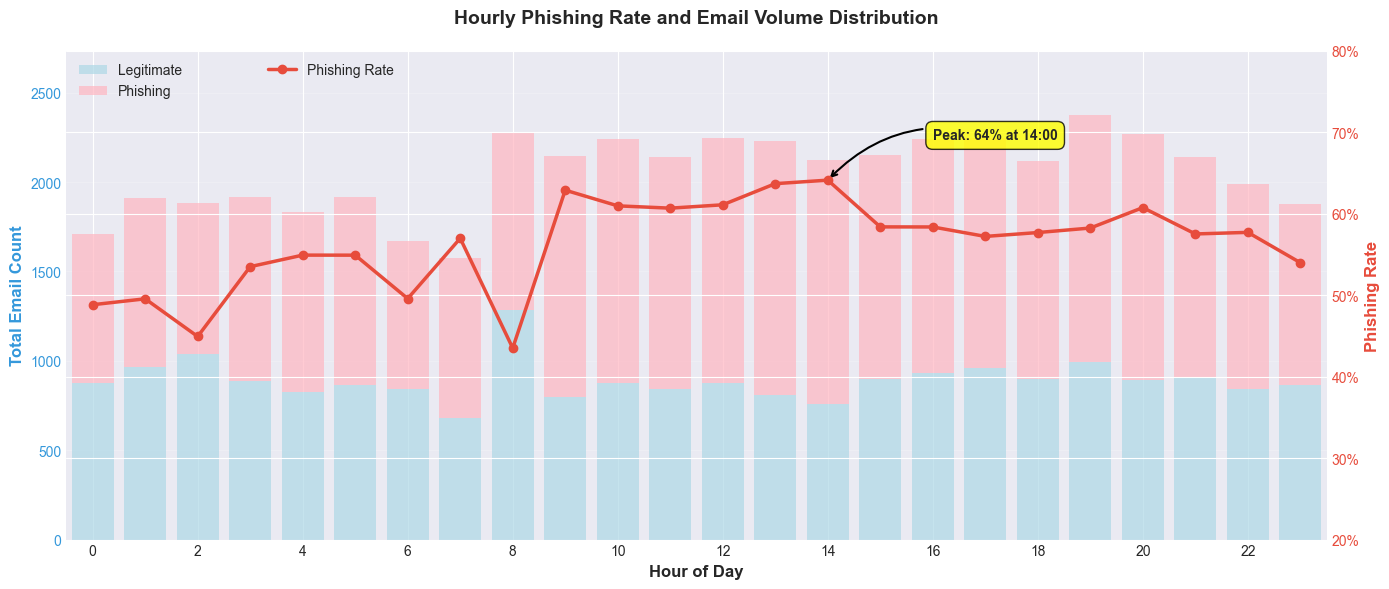

In [21]:
# --- Hourly Distribution Summary ---
# Calculate hourly statistics
hourly_stats = df_cleaned.groupby('hour').agg({
    'label': ['sum', 'count']
}).reset_index()
hourly_stats.columns = ['hour', 'phishing_count', 'total_count']
hourly_stats['phishing_rate'] = (hourly_stats['phishing_count'] / hourly_stats['total_count'] * 100)
hourly_stats['legitimate_count'] = hourly_stats['total_count'] - hourly_stats['phishing_count']

# Ensure all 24 hours are present
all_hours = pd.DataFrame({'hour': range(24)})
hourly_stats = all_hours.merge(hourly_stats, on='hour', how='left').fillna(0)

# Find peak hour
peak_hour = hourly_stats.loc[hourly_stats['phishing_rate'].idxmax()]

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

# Left axis: Stacked bars (Email Volume)
x_pos = hourly_stats['hour']
bars_legit = ax1.bar(x_pos, hourly_stats['legitimate_count'], 
                     label='Legitimate', color='#ADD8E6', alpha=0.7, 
                     edgecolor='none', width=0.8)
bars_phish = ax1.bar(x_pos, hourly_stats['phishing_count'], 
                     bottom=hourly_stats['legitimate_count'],
                     label='Phishing', color='#FFB6C1', alpha=0.7, 
                     edgecolor='none', width=0.8)

# Right axis: Line plot (Phishing Rate)
line = ax2.plot(hourly_stats['hour'], hourly_stats['phishing_rate'], 
                color='#E74C3C', marker='o', linewidth=2.5, markersize=6,
                label='Phishing Rate', zorder=10)

# Highlight peak hour with annotation
ax2.annotate(f'Peak: {peak_hour["phishing_rate"]:.0f}% at {int(peak_hour["hour"])}:00',
             xy=(peak_hour['hour'], peak_hour['phishing_rate']),
             xytext=(peak_hour['hour'] + 2, peak_hour['phishing_rate'] + 5),
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8, edgecolor='black'),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
                           color='black', lw=1.5))

# Customize left y-axis (Email Volume)
ax1.set_ylabel('Total Email Count', fontsize=12, fontweight='bold', color='#3498DB')
ax1.tick_params(axis='y', labelcolor='#3498DB')
ax1.set_ylim(0, max(hourly_stats['total_count']) * 1.15)

# Customize right y-axis (Phishing Rate)
ax2.set_ylabel('Phishing Rate', fontsize=12, fontweight='bold', color='#E74C3C')
ax2.tick_params(axis='y', labelcolor='#E74C3C')
ax2.set_ylim(20, 80)
ax2.set_yticks(range(20, 81, 10))
ax2.set_yticklabels([f'{y}%' for y in range(20, 81, 10)])

# Customize x-axis
ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax1.set_xticks(range(0, 24, 2))
ax1.set_xlim(-0.5, 23.5)

# Title
ax1.set_title('Hourly Phishing Rate and Email Volume Distribution', 
              fontsize=14, fontweight='bold', pad=20)

# Combined legend
bars_legend = ax1.legend(loc='upper left', fontsize=10, framealpha=0.9, edgecolor='black')
line_legend = ax2.legend(loc='upper left', bbox_to_anchor=(0.15, 1), 
                        fontsize=10, framealpha=0.9, edgecolor='black')

# Grid
ax1.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_axisbelow(True)

plt.tight_layout()

output_file = OUTPUT_DIR / '4.2.3_hourly_distribution.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Saved: {output_file}")

plt.show()
plt.close()

In [22]:
# --- Sender Behavioral Analysis: Prepare Data ---
from scipy.stats import chi2_contingency
from scipy import stats

# Calculate sender statistics
sender_stats = df_cleaned.groupby('sender').agg({
    'label': ['first', 'count']
}).reset_index()
sender_stats.columns = ['sender', 'label', 'total_emails']

# Split into legitimate and phishing senders
legitimate_senders = sender_stats[sender_stats['label'] == 0].copy()
phishing_senders = sender_stats[sender_stats['label'] == 1].copy()

# Calculate max emails per hour for each sender (using UTC time for accurate chronology)
max_emails_per_hour = df_cleaned.groupby('sender').apply(
    lambda x: x.set_index('utc_date').resample('1h').size().max()
).reset_index()
max_emails_per_hour.columns = ['sender', 'max_per_hour']

# Merge with sender stats
sender_stats = sender_stats.merge(max_emails_per_hour, on='sender', how='left')

# Split max_per_hour by class
legitimate_max = sender_stats[sender_stats['label'] == 0]['max_per_hour']
phishing_max = sender_stats[sender_stats['label'] == 1]['max_per_hour']

# Calculate time gaps between emails for multi-email senders (using UTC time for accurate chronology)
df_sorted = df_cleaned.sort_values(['sender', 'utc_date'])
df_sorted['time_gap'] = df_sorted.groupby('sender')['utc_date'].diff()
df_sorted['gap_minutes'] = df_sorted['time_gap'].dt.total_seconds() / 60

time_gaps = df_sorted[df_sorted['gap_minutes'].notna()][['sender', 'gap_minutes']].copy()
time_gaps = time_gaps.merge(sender_stats[['sender', 'label']], on='sender', how='left')
time_gaps['sender_type'] = time_gaps['label'].map({0: 'Legitimate', 1: 'Phishing'})

print("✅ Sender behavioral data prepared (using UTC time for accurate chronology)")

✅ Sender behavioral data prepared (using UTC time for accurate chronology)


/var/folders/bs/rgms05cn523bt4l81pl47lhc0000gn/T/ipykernel_1217/1409261587.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_emails_per_hour = df_cleaned.groupby('sender').apply(


/var/folders/bs/rgms05cn523bt4l81pl47lhc0000gn/T/ipykernel_1217/2007038338.py:151: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[2].boxplot([legit_gaps_log, phish_gaps_log],



⏳ Analyzing sender behavioral patterns...
✅ Panel A: Phishing ≤1/hr=98.3%, Legit ≤1/hr=75.8%
✅ Panel B: Phishing single-use=97.3%, Legit=50.8%
✅ Panel C: Phishing median=1.0min, Legit=44.9min

🎨 Creating 3-panel figure...
✅ Saved: ../../figures/4.2.3_sender_behavioral_patterns.png


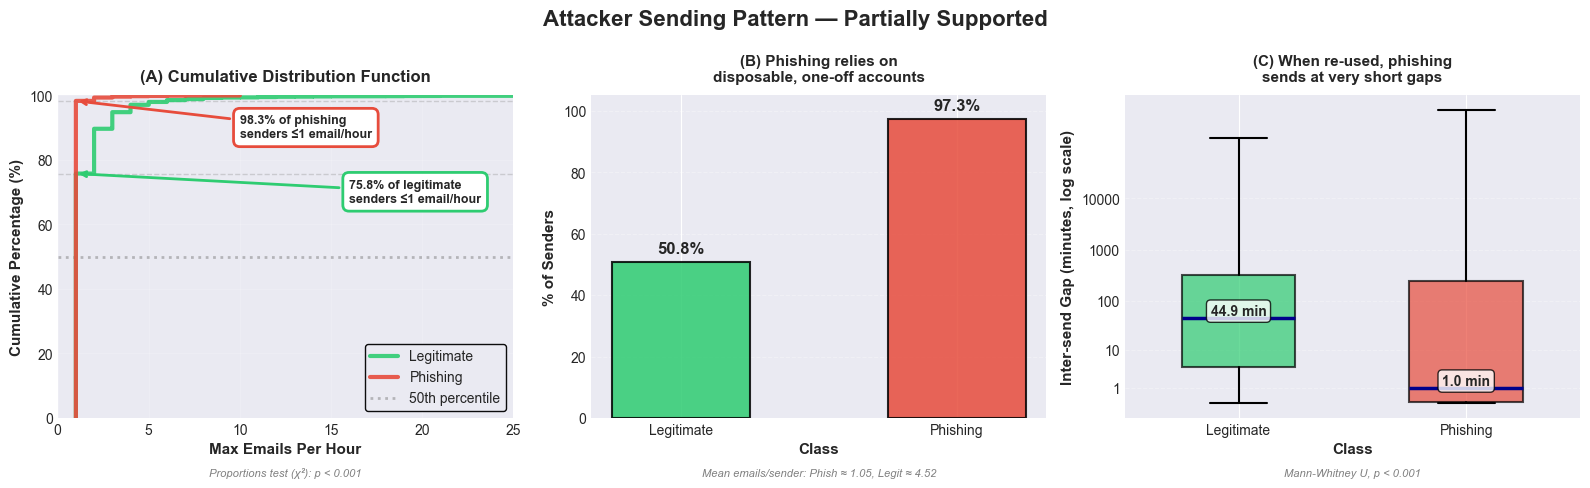

In [23]:
# =============================================================================
# CREATE 3-PANEL SENDER BEHAVIORAL FIGURE
# =============================================================================

print("\n⏳ Analyzing sender behavioral patterns...")

# --- Panel A: Burst data ---
legit_burst_low_pct = (legitimate_max <= 1).mean() * 100
phish_burst_low_pct = (phishing_max <= 1).mean() * 100

legit_burst_low = (legitimate_max <= 1).sum()
legit_burst_high = (legitimate_max > 1).sum()
phish_burst_low = (phishing_max <= 1).sum()
phish_burst_high = (phishing_max > 1).sum()

burst_contingency = np.array([[legit_burst_low, legit_burst_high],
                               [phish_burst_low, phish_burst_high]])
chi2_burst, p_burst, dof_burst, expected_burst = chi2_contingency(burst_contingency)

print(f"✅ Panel A: Phishing ≤1/hr={phish_burst_low_pct:.1f}%, Legit ≤1/hr={legit_burst_low_pct:.1f}%")

# --- Panel B: Single-use data ---
legit_single_pct = (legitimate_senders['total_emails'] == 1).mean() * 100
phish_single_pct = (phishing_senders['total_emails'] == 1).mean() * 100
legit_mean_emails = legitimate_senders['total_emails'].mean()
phish_mean_emails = phishing_senders['total_emails'].mean()

print(f"✅ Panel B: Phishing single-use={phish_single_pct:.1f}%, Legit={legit_single_pct:.1f}%")

# --- Panel C: Inter-send gaps ---
multi_email_senders = sender_stats[sender_stats['total_emails'] >= 2]['sender']
time_gaps_multi = time_gaps[time_gaps['sender'].isin(multi_email_senders)]
legit_gaps_multi = time_gaps_multi[time_gaps_multi['sender_type'] == 'Legitimate']['gap_minutes']
phish_gaps_multi = time_gaps_multi[time_gaps_multi['sender_type'] == 'Phishing']['gap_minutes']

legit_median_gap = legit_gaps_multi.median()
phish_median_gap = phish_gaps_multi.median()
stat_mw, p_mw = stats.mannwhitneyu(legit_gaps_multi, phish_gaps_multi, alternative='two-sided')

print(f"✅ Panel C: Phishing median={phish_median_gap:.1f}min, Legit={legit_median_gap:.1f}min")

print("\n🎨 Creating 3-panel figure...")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Attacker Sending Pattern — Partially Supported', 
             fontsize=16, fontweight='bold', y=0.99)

# Colors
legit_color = '#2ecc71'  # Green
phish_color = '#e74c3c'  # Red

# =============================================================================
# PANEL A: Cumulative Distribution Function
# =============================================================================

# Calculate ECDF
legit_sorted = np.sort(legitimate_max)
phish_sorted = np.sort(phishing_max)
legit_ecdf = np.arange(1, len(legit_sorted) + 1) / len(legit_sorted) * 100
phish_ecdf = np.arange(1, len(phish_sorted) + 1) / len(phish_sorted) * 100

# Plot CDFs
axes[0].plot(legit_sorted, legit_ecdf, 
            label='Legitimate', linewidth=3, color=legit_color, 
            alpha=0.9, drawstyle='steps-post')
axes[0].plot(phish_sorted, phish_ecdf, 
            label='Phishing', linewidth=3, color=phish_color, 
            alpha=0.9, drawstyle='steps-post')

# Add 50th percentile reference line
axes[0].axhline(y=50, color='gray', linestyle=':', linewidth=2, 
               alpha=0.5, label='50th percentile', zorder=1)

# Add horizontal guide lines
axes[0].axhline(y=phish_burst_low_pct, color='gray', linestyle='--', 
               linewidth=1, alpha=0.3, zorder=1)
axes[0].axhline(y=legit_burst_low_pct, color='gray', linestyle='--', 
               linewidth=1, alpha=0.3, zorder=1)

# Annotations
axes[0].annotate(f'{phish_burst_low_pct:.1f}% of phishing\nsenders ≤1 email/hour', 
                xy=(1, phish_burst_low_pct),
                xytext=(10, 87),
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                         edgecolor=phish_color, linewidth=2),
                arrowprops=dict(arrowstyle='->', color=phish_color, lw=2),
                zorder=5)

axes[0].annotate(f'{legit_burst_low_pct:.1f}% of legitimate\nsenders ≤1 email/hour', 
                xy=(1, legit_burst_low_pct),
                xytext=(16, 67),
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                         edgecolor=legit_color, linewidth=2),
                arrowprops=dict(arrowstyle='->', color=legit_color, lw=2),
                zorder=5)

axes[0].set_xlabel('Max Emails Per Hour', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Cumulative Percentage (%)', fontsize=11, fontweight='bold')
axes[0].set_title('(A) Cumulative Distribution Function', 
                  fontsize=12, fontweight='bold', pad=10)
axes[0].set_xlim(0, 25)
axes[0].set_ylim(0, 100)
axes[0].legend(loc='lower right', fontsize=10, framealpha=0.95, 
              edgecolor='black', frameon=True)
axes[0].grid(True, alpha=0.25, linestyle='-', linewidth=0.5, zorder=0)
axes[0].set_axisbelow(True)
axes[0].text(0.5, -0.18, f'Proportions test (χ²): p < 0.001', 
            transform=axes[0].transAxes, ha='center', fontsize=8, 
            style='italic', color='gray')

# =============================================================================
# PANEL B: Disposable accounts
# =============================================================================

categories = ['Legitimate', 'Phishing']
single_use_data = [legit_single_pct, phish_single_pct]
colors_b = [legit_color, phish_color]

x_pos = np.arange(len(categories))
width = 0.5

bars = axes[1].bar(x_pos, single_use_data, width, color=colors_b, 
                   alpha=0.85, edgecolor='black', linewidth=1.5)

for i, (bar, pct) in enumerate(zip(bars, single_use_data)):
    axes[1].text(i, pct + 2, f'{pct:.1f}%', 
                ha='center', va='bottom', fontweight='bold', fontsize=12)

axes[1].set_ylabel('% of Senders', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=11, fontweight='bold')
axes[1].set_title('(B) Phishing relies on\ndisposable, one-off accounts', 
                  fontsize=11, fontweight='bold', pad=10)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(categories, fontsize=10)
axes[1].set_ylim(0, 105)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

axes[1].text(0.5, -0.18, f'Mean emails/sender: Phish ≈ {phish_mean_emails:.2f}, Legit ≈ {legit_mean_emails:.2f}',
            transform=axes[1].transAxes, ha='center', fontsize=8, 
            style='italic', color='gray')

# =============================================================================
# PANEL C: Rapid cadence when re-used
# =============================================================================

legit_gaps_log = np.log10(legit_gaps_multi + 1)
phish_gaps_log = np.log10(phish_gaps_multi + 1)

bp = axes[2].boxplot([legit_gaps_log, phish_gaps_log], 
                      labels=categories,
                      patch_artist=True, widths=0.5,
                      boxprops=dict(linewidth=1.5),
                      medianprops=dict(color='darkblue', linewidth=2.5),
                      whiskerprops=dict(linewidth=1.5),
                      capprops=dict(linewidth=1.5),
                      showfliers=False)

bp['boxes'][0].set_facecolor(legit_color)
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor(phish_color)
bp['boxes'][1].set_alpha(0.7)

axes[2].set_ylabel('Inter-send Gap (minutes, log scale)', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Class', fontsize=11, fontweight='bold')
axes[2].set_title('(C) When re-used, phishing\nsends at very short gaps', 
                  fontsize=11, fontweight='bold', pad=10)
axes[2].grid(axis='y', alpha=0.3, linestyle='--')

medians_log = [np.log10(legit_median_gap + 1), np.log10(phish_median_gap + 1)]
for i, (median_log, median_actual) in enumerate(zip(medians_log, [legit_median_gap, phish_median_gap])):
    axes[2].text(i+1, median_log, f'{median_actual:.1f} min', 
                ha='center', va='bottom', fontweight='bold', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='black', alpha=0.8))

axes[2].text(0.5, -0.18, 'Mann-Whitney U, p < 0.001',
            transform=axes[2].transAxes, ha='center', fontsize=8, 
            style='italic', color='gray')

y_ticks_log = np.log10(np.array([1, 10, 100, 1000, 10000]) + 1)
y_tick_labels = ['1', '10', '100', '1000', '10000']
axes[2].set_yticks(y_ticks_log)
axes[2].set_yticklabels(y_tick_labels)

# =============================================================================
# FINALIZE
# =============================================================================

plt.tight_layout()

output_file = OUTPUT_DIR / '4.2.3_sender_behavioral_patterns.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Saved: {output_file}")

plt.show()
plt.close()


```python

# Selected features for modeling
model_features = [
    'timezone_region',
    'is_night',
    'sender_historical_phishing_rate',
    'sender_historical_count',
    'current_time_gap',
    'sender_time_gap_std'
]
```